# Modeling Workflow

In [1]:
%matplotlib inline
import tellurium as te
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import lmfit
import util

## Review of Model Fitting

In [2]:
import lmfit
import numpy

def calculate(x, amp, phase, freq, decay):
    """
    :param Parameters params:
    :param array x: independent variable(s)
    :param array data: observed values to fit to
    """
    return amp*np.sin(x*freq + phase)*np.exp(-x*x*decay)
    
# Synthetic data
x = np.linspace(0, 10, 100)
AMP = 3.0
FREQ = 1.0
PHASE = 0.0
DECAY = 0.1
data = calculate(x, AMP, PHASE, FREQ, DECAY)


# Fitting
params = lmfit.Parameters()
params.add('amp', value=10)
params.add('freq', value=3)
params.add('phase', value=.2)
params.add('decay', value = 1.0)
#
model = lmfit.Model(calculate)
fitter = model.fit(data, params, x=x) 
fitter.params


Parameters([('amp',
             <Parameter 'amp', value=3.00000000084041 +/- 1.26e-10, bounds=[-inf:inf]>),
            ('freq',
             <Parameter 'freq', value=1.0000000002562435 +/- 2.1e-11, bounds=[-inf:inf]>),
            ('phase',
             <Parameter 'phase', value=-2.732487809161068e-10 +/- 4.37e-11, bounds=[-inf:inf]>),
            ('decay',
             <Parameter 'decay', value=0.10000000004427274 +/- 1.02e-11, bounds=[-inf:inf]>)])

In [3]:
print(fitter.fit_report())

[[Model]]
    Model(calculate)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 100
    # variables        = 4
    chi-square         = 8.5714e-18
    reduced chi-square = 8.9285e-20
    Akaike info crit   = -4382.32720
    Bayesian info crit = -4371.90652
[[Variables]]
    amp:    3.00000000 +/- 1.2630e-10 (0.00%) (init = 10)
    freq:   1.00000000 +/- 2.0970e-11 (0.00%) (init = 3)
    phase: -2.7325e-10 +/- 4.3739e-11 (16.01%) (init = 0.2)
    decay:  0.10000000 +/- 1.0233e-11 (0.00%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decay)  =  0.652
    C(freq, decay) = -0.141
    C(amp, freq)   = -0.108



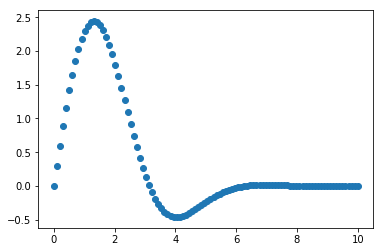

In [4]:
plt.scatter(x, data)

In [5]:
print(fitter.fit_report())

[[Model]]
    Model(calculate)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 100
    # variables        = 4
    chi-square         = 8.5714e-18
    reduced chi-square = 8.9285e-20
    Akaike info crit   = -4382.32720
    Bayesian info crit = -4371.90652
[[Variables]]
    amp:    3.00000000 +/- 1.2630e-10 (0.00%) (init = 10)
    freq:   1.00000000 +/- 2.0970e-11 (0.00%) (init = 3)
    phase: -2.7325e-10 +/- 4.3739e-11 (16.01%) (init = 0.2)
    decay:  0.10000000 +/- 1.0233e-11 (0.00%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decay)  =  0.652
    C(freq, decay) = -0.141
    C(amp, freq)   = -0.108



In [6]:
fitter.params.get('amp').value

3.00000000084041

In [7]:
for name in fitter.params:
    print (name)

amp
freq
phase
decay


In [8]:
for name in fitter.params:
    param = fitter.params.get(name)
    stmt = "%s = %3.4f" % (name, param.value)
    exec(stmt)
fit = calculate(x, amp, freq, phase, decay)

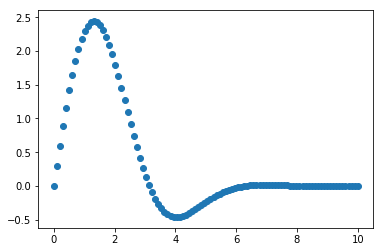

In [9]:

plt.scatter(x, model.eval(fitter.params, x=x))

Text(0,0.5,'Fitted')

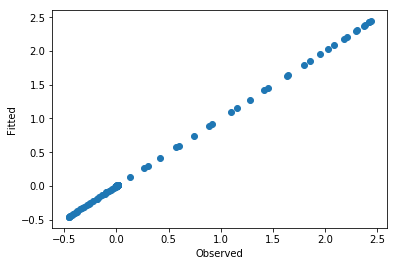

In [10]:
# Plot the result
plt.scatter(data,  model.eval(fitter.params, x=x))
plt.xlabel("Observed")
plt.ylabel("Fitted")

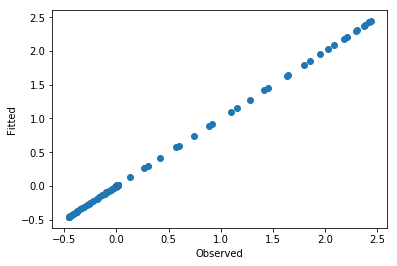

In [11]:
# We will do this a lot. A better way is to make a function that does the plot.
util.plotFit(data, model.eval(fitter.params, x=x))

## Fitting a Simulation to One Species Concentration
1. Make simulation into a function
1. Create observations
1. Create parameters
1. Fit the model
1. Generate fitted simulation data
1. Compare the fit with the data

In [12]:
# Encapsulate the simulation into a function

# Use constants, not numbers, so that values can be changed easily and promote readability.
START = 0
STOP = 50
NUM_POINTS = 100
def simulateModel(v0, ka, kb, kc):
    """
    Simulate the model for specific parameter values.
    :param array x: dummy independent variable
    :return array-float: [B]
    """
    model = """
    model test
        species A, B, C;

        J0: -> A; v0
        A -> B; ka*A;
        B -> C; kb*B;
        J1: C ->; C*kc
        A = 0
        B = 0
        C = 0
        v0 = 10
        ka = 0.4
        kb = 0.8*ka
        kc = ka

    end
    """
    r = te.loada(model)
    r.v0 = v0
    r.ka = ka
    r.kb = kb
    r.kc =kc
    return r.simulate(START, STOP, NUM_POINTS)
    
def simulate(v0=10, ka=0.4, kb=0.32, kc=0.4):
    results = simulateModel(v0, ka, kb, kc)
    return results["[B]"]

In [13]:
# Generate synthetic observations
STD = 1.0
data = simulate() + np.random.normal(0, STD, NUM_POINTS)

In [14]:
# Create the parameters of simulation
params = lmfit.Parameters()
params.add('v0', value=100, min=0)
params.add('ka', value=.1, min=0)
params.add('kb', value=.1, min=0)
params.add('kc', value = 0.1, min=0)

In [15]:
# Do the fit
model = lmfit.Model(simulate, independent_vars=[], method='leastsq')  # Specifying no independent variables
fitter = model.fit(data, params) 
fitter.params

Parameters([('v0',
             <Parameter 'v0', value=626.1346457916108 +/- 2.7, bounds=[0:inf]>),
            ('ka',
             <Parameter 'ka', value=0.6535118999996627 +/- 0.00387, bounds=[0:inf]>),
            ('kb',
             <Parameter 'kb', value=21.360825878630706 +/- 0.0267, bounds=[0:inf]>),
            ('kc',
             <Parameter 'kc', value=3506567.8136108043 +/- 1.19e+05, bounds=[0:inf]>)])

In [16]:
print( fitter.fit_report())

[[Model]]
    Model(simulate)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 100
    # variables        = 4
    chi-square         = 2530.49933
    reduced chi-square = 26.3593681
    Akaike info crit   = 331.100174
    Bayesian info crit = 341.520855
[[Variables]]
    v0:  626.134646 +/- 2.70205867 (0.43%) (init = 100)
    ka:  0.65351190 +/- 0.00386763 (0.59%) (init = 0.1)
    kb:  21.3608259 +/- 0.02669422 (0.12%) (init = 0.1)
    kc:  3506567.81 +/- 118861.576 (3.39%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(v0, ka) = -0.984
    C(ka, kb) =  0.532
    C(v0, kb) = -0.505
    C(kb, kc) = -0.389
    C(v0, kc) = -0.109



In [17]:
# Run the simulation to get fitted values
fit = fitter.eval(fitter.params)

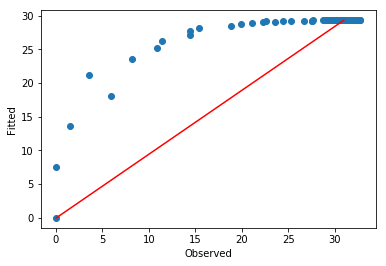

In [18]:
util.plotFit(data, fit)

## Fitting With Multiple Concentrations
The key challenge here is how to do the fit so that we take into account the residuals of all species concentrations.
1. Create synthetic data for all concentrations
1. Create simulateMultiple that returns residuals from simulating multiple concentrations
1. Fit to an array of 0s

In [19]:
# Create synthetic data
data = simulateModel(10, 0.4, 0.32, 0.4)
for idx, _ in enumerate(data.colnames[1:]):
    data[:, idx] += np.random.normal(0, STD, len(data))

In [20]:
def simulateMultiple(x, v0=10, ka=0.4, kb=0.32, kc=0.4):
    """
    :param NamedArray-float data: observed data
    :return sum of residuals for all concentrations
    """
    results = simulateModel(v0, ka, kb, kc)
    residuals = data['time'] - x['time']
    for idx, _ in enumerate(data.colnames[1:]):
        residuals += data[:, idx] - results[:, idx]
    return residuals

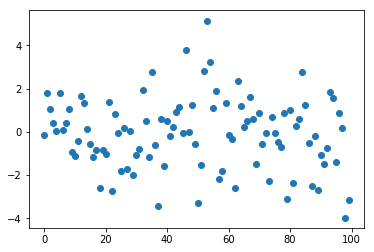

In [21]:
residuals = simulateMultiple(data)
plt.scatter(range(len(data)), residuals)

In [22]:
# Create the parameters of simulation
params = lmfit.Parameters()
params.add('v0', value=100, min=0)
params.add('ka', value=.1, min=0)
params.add('kb', value=.1, min=0)
params.add('kc', value = 0.1, min=0)
# Do the fit
model = lmfit.Model(simulateMultiple, method='nelder')  # Specifying no independent variables
residuals = np.repeat(0., NUM_POINTS)
fitter = model.fit(residuals, params, x=data) 
fitter.params

Parameters([('v0',
             <Parameter 'v0', value=1742.3885889037817 +/- 3.64e+08, bounds=[0:inf]>),
            ('ka',
             <Parameter 'ka', value=66.72942254435308 +/- 5.11e+07, bounds=[0:inf]>),
            ('kb',
             <Parameter 'kb', value=68.13881755074753 +/- 2.46e+07, bounds=[0:inf]>),
            ('kc',
             <Parameter 'kc', value=45935819.32324559 +/- 1.1e+13, bounds=[0:inf]>)])

In [23]:
print(fitter.fit_report())

[[Model]]
    Model(simulateMultiple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 100
    # variables        = 4
    chi-square         = 10630.1543
    reduced chi-square = 110.730774
    Akaike info crit   = 474.627980
    Bayesian info crit = 485.048661
[[Variables]]
    v0:  1742.38859 +/- 3.6436e+08 (20911333.99%) (init = 100)
    ka:  66.7294225 +/- 51115624.8 (76601329.38%) (init = 0.1)
    kb:  68.1388176 +/- 24629634.2 (36146260.12%) (init = 0.1)
    kc:  45935819.3 +/- 1.1011e+13 (23969872.28%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(ka, kc) =  0.999
    C(v0, kc) =  0.999
    C(v0, ka) =  0.998
    C(ka, kb) = -0.997
    C(kb, kc) = -0.994
    C(v0, kb) = -0.990



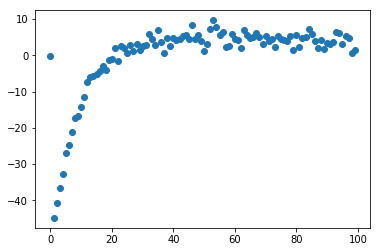

In [24]:
plt.scatter(range(NUM_POINTS), model.eval(fitter.params, x=data))

## Fit With Cross Validation

In [107]:
def convertResultsToArray(results):
    """
    Concatentates the non-time columns of a simulation result
    by alternating columns for rows.
    :param NamedArray results
    """
    num_cols = results.shape[1]
    results = results[:, 1:]
    new_length = len(results)*(num_cols - 1)
    array = results.reshape(new_length)
    return array

In [122]:
# Generate synthetic observations
STD = 1.0
def generateObservations(std=STD):
    """
    :return NamedArray: simulation results with normal errors
    """
    v0=10; ka=0.4; kb=0.32; kc=0.4;
    results = simulateModel(v0, ka, kb, kc)
    columns = results.colnames
    for col in range(1, len(results.colnames)):
        for row in range(len(results)):
            results[row, col] = max(results[row, col], 0)
    results.colnames = columns
    return results

In [123]:
generateObservations()

        time,     [A],     [B],       [C]
 [[        0,       0,       0,         0],
  [ 0.505051, 4.57304, 0.45235, 0.0238755],
  [   1.0101, 8.30957, 1.60751,  0.166169],
  [  1.51515, 11.3626, 3.21968,  0.488618],
  [   2.0202, 13.8572, 5.10554,   1.01061],
  [  2.52525, 15.8954, 7.13017,   1.72499],
  [   3.0303, 17.5609,   9.196,   2.60907],
  [  3.53535, 18.9216, 11.2341,   3.63234],
  [   4.0404, 20.0335, 13.1972,   4.76148],
  [  4.54545,  20.942, 15.0547,   5.96365],
  [  5.05051, 21.6843,  16.788,   7.20851],
  [  5.55556, 22.2908, 18.3877,   8.46927],
  [  6.06061, 22.7864, 19.8508,   9.72317],
  [  6.56566, 23.1913, 21.1791,   10.9516],
  [  7.07071, 23.5221, 22.3773,   12.1398],
  [  7.57576, 23.7925, 23.4525,   13.2765],
  [  8.08081, 24.0134, 24.4127,   14.3539],
  [  8.58586, 24.1938, 25.2669,   15.3666],
  [  9.09091, 24.3413,  26.024,   16.3116],
  [  9.59596, 24.4618, 26.6929,   17.1877],
  [   10.101, 24.5602, 27.2823,   17.9954],
  [  10.6061, 24.6407, 27.8003,   

In [110]:
# Generate synthetic observations
STD = 1.0
def generateObservations(std=STD):
    """
    :return NamedArray: simulation results with normal errors
    """
    v0=10; ka=0.4; kb=0.32; kc=0.4;
    results = simulateModel(v0, ka, kb, kc)
    for idx in range(1, len(results.colnames)):
        results[:, idx] = results[:, idx] + np.random.normal(0, STD)

In [111]:
# Uses the independent variable to pass the indices to report
def simulateWithIndices(x, v0, ka, kb, kc):
    results = simulateModel(v0, ka, kb, kc)
    results = results[x]
    return convertResultsToArray(results)

In [112]:
# Create the parameters of simulation
params = lmfit.Parameters()
params.add('v0', value=100, min=0)
params.add('ka', value=.1, min=0)
params.add('kb', value=.1, min=0)
params.add('kc', value = 0.1, min=0)

In [124]:
# Create the fold generator
NUM_FOLDS = 4
data = generateObservations()
generator = util.foldGenerator(NUM_POINTS, NUM_FOLDS)
eval_statistics = []  # Acccumulates statistics
# Fit training data and evaluate on test data for each fold
for train, test in generator:
    # Do the fit
    model = lmfit.Model(simulateWithIndices, method='leastsq')  # Specifying no independent variables
    data_train = convertResultsToArray(data[train])
    fitter = model.fit(data_train, params, x=train) 
    fit = model.eval(fitter.params, x=test)
    data_test = convertResultsToArray(data[test])
    eval_statistics.append(r2_score(data_test, fit))
# Report the results
print("Mean R2: %2.3f,  Std R2: %2.3f" % (np.mean(eval_statistics), np.std(eval_statistics)))

Mean R2: 1.000,  Std R2: 0.000


In [115]:
data

## Estimate Parameter Variability With Bootstrapping